# Program for analysizing ISIMIP3a yields data
## This program is to check if the crop models can regenerate real maize production for the perods

##### The comparison of simulated production covers the 20-year period from 1996 to 2014, during which the crop models are driven by observed climate data. This comparison involves two distinct approaches. Firstly, it evaluates the 20-year average maize production modeled by each of the 11 individual models and the ensemble mean against the average maize production derived from 3-year SPAM data, assumed to represent the true production over the 20-year period. Secondly, it assesses the production for each of the 3 years individually for each model and the ensemble mean.

In [1]:
import glob
import os
# Ignore warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

#Process data
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
#Display data 
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.vector_transform import vector_scalar_to_grid
from matplotlib.axes import Axes
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.image as image
import matplotlib.pyplot as plt


## 1. check availability of dataset

Load 2000, 2005 and 2010 SPAM production data. 

In [3]:
#this file is in the data folder in github repository
spam_production=np.load('average_all.npy')
spam_production=np.where(spam_production <= 0, np.nan, spam_production)

In [4]:
min_lon = -100 
min_lat = 35
max_lon = -70
max_lat = 65
min_time=334  #1995
max_time=353  #2014

In [5]:
Path='/media/Data1/Climada/isimip3/nc4/'
gcms=['gfdl-esm4','ipsl-cm6a-lr','mpi-esm1-2-hr','mri-esm2-0','ukesm1-0-ll']
ggcms=['acea','crover','cygma1p74','dssat-pythia','epic-iiasa','isam',
       'ldndc','lpjml','pdssat','pepic','promet','simplace-lintul5']

### 1.1 Landuse data in percentages

In [6]:
#this file is downlowded from  ISIMIP site: https://data.isimip.org/files/edbdc287-e678-45ef-942f-137327dba6fa/
fn1 = '/media/Data1/Climada/ISIMIP/data/landuse-15crops_2015soc_annual_1850_2014.nc'
ds_landuse=xr.open_dataset(fn1,decode_times=False)
ds1995to2014=ds_landuse.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(min_time,max_time))

ds2000=ds_landuse.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(339,339))
ds2005=ds_landuse.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(344,344))
ds2010=ds_landuse.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(349,349))

maize_rainfed_landuse_in_percentage_1995to2014 = ds1995to2014["maize_rainfed"]*100
maize_irrigated_landuse_in_percentage_1995to2014 = ds1995to2014["maize_irrigated"]*100

maize_rainfed_landuse_in_percentage_1995to2014_average = ds1995to2014["maize_rainfed"].mean(dim='time')*100
maize_irrigated_landuse_in_percentage_1995to2014_average = ds1995to2014["maize_irrigated"].mean(dim='time')*100

maize_rainfed_landuse_in_percentage_2000 = ds2000["maize_rainfed"].mean(dim='time')*100
maize_irrigated_landuse_in_percentage_2000 = ds2000["maize_irrigated"].mean(dim='time')*100

maize_rainfed_landuse_in_percentage_2005 = ds2005["maize_rainfed"].mean(dim='time')*100
maize_irrigated_landuse_in_percentage_2005 = ds2005["maize_irrigated"].mean(dim='time')*100

maize_rainfed_landuse_in_percentage_2010 = ds2010["maize_rainfed"].mean(dim='time')*100
maize_irrigated_landuse_in_percentage_2010 = ds2010["maize_irrigated"].mean(dim='time')*100


In [7]:
#this file is in the github repository
areainsqmeter=np.load('originalcode/code/ipynb/areainsqmeter_squared_meter_great_lake_region_35N65N.npy')

In [8]:
## check content in the data file
## this file is downloaded from GGCMI site: https://www.pik-potsdam.de/~jonasjae/GGCMI_Phase3a_by_GGCM_1979_2015/
file='/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_simplace-lintul5_gswp3-w5e5_default_annual_mai_yield_and_production.nc4'
ds=xr.open_dataset(file,decode_times=False)
ds

<xarray.Dataset>
Dimensions:     (lon: 720, lat: 360, years: 37, irr: 2)
Coordinates:
  * lon         (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat         (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * years       (years) int32 1979 1980 1981 1982 1983 ... 2012 2013 2014 2015
  * irr         (irr) float64 1.0 2.0
Data variables:
    yield       (irr, years, lat, lon) float64 ...
    production  (irr, years, lat, lon) float64 ...

In [9]:
#check if all data are available
## all these file are downloaded from: https://www.pik-potsdam.de/~jonasjae/GGCMI_Phase3a_by_GGCM_1979_2015/
fns=glob.glob("/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_*default_annual_mai_yield_and_production.nc4")
len(fns)


11

In [10]:
fns

['/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_simplace-lintul5_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_cygma1p74_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pepic_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_epic-iiasa_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_crover_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pdssat_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_isam_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_lpjml_gswp3-w5e5_default_annual_mai_yield_and_production.nc4',
 '/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3

## 2. Below is an example to display what information in the data file

### 2.1 Check data from GGCMI

In [11]:
# from https://www.pik-potsdam.de/~jonasjae/GGCMI_Phase3a_by_GGCM_1979_2015/
fn='/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_acea_gswp3-w5e5_default_annual_mai_yield_and_production.nc4'
ds=xr.open_dataset(fn,decode_times=False)
ds

<xarray.Dataset>
Dimensions:     (lon: 720, lat: 360, years: 37, irr: 2)
Coordinates:
  * lon         (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat         (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * years       (years) int32 1979 1980 1981 1982 1983 ... 2012 2013 2014 2015
  * irr         (irr) float64 1.0 2.0
Data variables:
    yield       (irr, years, lat, lon) float64 ...
    production  (irr, years, lat, lon) float64 ...

In [12]:
cropped_ds00 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('2015','2015'), irr=1.0)
cropped_ds01 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('2015','2015'), irr=2.0)
cropped_ds00  

<xarray.Dataset>
Dimensions:     (lon: 60, lat: 60, years: 1)
Coordinates:
  * lon         (lon) float64 -99.75 -99.25 -98.75 ... -71.25 -70.75 -70.25
  * lat         (lat) float64 64.75 64.25 63.75 63.25 ... 36.25 35.75 35.25
  * years       (years) int32 2015
    irr         float64 1.0
Data variables:
    yield       (years, lat, lon) float64 ...
    production  (years, lat, lon) float64 ...

In [13]:
cropped_ds00['yield'].values.squeeze()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [14]:
cropped_ds01

<xarray.Dataset>
Dimensions:     (lon: 60, lat: 60, years: 1)
Coordinates:
  * lon         (lon) float64 -99.75 -99.25 -98.75 ... -71.25 -70.75 -70.25
  * lat         (lat) float64 64.75 64.25 63.75 63.25 ... 36.25 35.75 35.25
  * years       (years) int32 2015
    irr         float64 2.0
Data variables:
    yield       (years, lat, lon) float64 ...
    production  (years, lat, lon) float64 ...

### 2.2 Check data from isimip3

In [15]:
## this file is downloaded from ISIMIP site: https://data.isimip.org/files/cd500114-9319-411d-be9a-47a61978c171/
file='/media/Data1/Climada/isimip3/maize3a/acea_gswp3-w5e5_obsclim_2015soc_default_yield-mai-noirr_global_annual-gs_1901_2016.nc'
ds2=xr.open_dataset(file,decode_times=False)
cropped_ds10 = ds2.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(114,114.0))
cropped_ds10

<xarray.Dataset>
Dimensions:          (lon: 60, lat: 60, time: 1)
Coordinates:
  * lon              (lon) float64 -99.75 -99.25 -98.75 ... -71.25 -70.75 -70.25
  * lat              (lat) float64 64.75 64.25 63.75 63.25 ... 36.25 35.75 35.25
  * time             (time) float64 114.0
Data variables:
    yield-mai-noirr  (time, lat, lon) float32 ...
Attributes:
    title:                    ACEA simulations for Ag-GRID GGCMI Phase 3 project
    institution:              University of Twente, Netherlands
    contact:                  Oleks Mialyk o.mialyk@utwente.nl
    isimip_comment:           Data is taken from GGCMI (AgMIP) Phase 3a and r...
    isimip_id:                cd500114-9319-411d-be9a-47a61978c171
    isimip_protocol_version:  027342a3356372791ca6318f6bd552ee712cfd4a
    isimip_qc_version:        3.0.2
    isimip_qc_pass_date:      2023-07-20 13:43 UTC

In [16]:
# this file is downloaded from ISIMIP https://data.isimip.org/files/b8e236a6-6ac8-4f8a-924f-a621891b1ba5/
file='/media/Data1/Climada/isimip3/maize3a/acea_gswp3-w5e5_obsclim_2015soc_default_yield-mai-firr_global_annual-gs_1901_2016.nc'
ds1=xr.open_dataset(file,decode_times=False)
ds1

<xarray.Dataset>
Dimensions:         (lon: 720, lat: 360, time: 116)
Coordinates:
  * lon             (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat             (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * time            (time) float64 0.0 1.0 2.0 3.0 ... 112.0 113.0 114.0 115.0
Data variables:
    yield-mai-firr  (time, lat, lon) float32 ...
Attributes:
    title:                    ACEA simulations for Ag-GRID GGCMI Phase 3 project
    institution:              University of Twente, Netherlands
    contact:                  Oleks Mialyk o.mialyk@utwente.nl
    isimip_comment:           Data is taken from GGCMI (AgMIP) Phase 3a and r...
    isimip_id:                b8e236a6-6ac8-4f8a-924f-a621891b1ba5
    isimip_protocol_version:  027342a3356372791ca6318f6bd552ee712cfd4a
    isimip_qc_version:        3.0.2
    isimip_qc_pass_date:      2023-07-20 13:43 UTC

In [17]:
cropped_ds11 = ds1.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(114,114))
cropped_ds11  

<xarray.Dataset>
Dimensions:         (lon: 60, lat: 60, time: 1)
Coordinates:
  * lon             (lon) float64 -99.75 -99.25 -98.75 ... -71.25 -70.75 -70.25
  * lat             (lat) float64 64.75 64.25 63.75 63.25 ... 36.25 35.75 35.25
  * time            (time) float64 114.0
Data variables:
    yield-mai-firr  (time, lat, lon) float32 ...
Attributes:
    title:                    ACEA simulations for Ag-GRID GGCMI Phase 3 project
    institution:              University of Twente, Netherlands
    contact:                  Oleks Mialyk o.mialyk@utwente.nl
    isimip_comment:           Data is taken from GGCMI (AgMIP) Phase 3a and r...
    isimip_id:                b8e236a6-6ac8-4f8a-924f-a621891b1ba5
    isimip_protocol_version:  027342a3356372791ca6318f6bd552ee712cfd4a
    isimip_qc_version:        3.0.2
    isimip_qc_pass_date:      2023-07-20 13:43 UTC

## 3. Check the ratio of production from model against the production from SPAM data


### 3.1 Comparison of 20-year averages

In [18]:
name_ggcms=['(a) simplace-lintul5','(b) cygma1p74','(c) pepic','(d) epic-iiasa','(e) crover','(f)pdssat',
       '(g) isam','(h) lpjml','(i) ldndc','(j) promet','(k) acea','(l) Ensemble']

#### 3.1.1 Calculate annual production

In [19]:
# calculated in 1.1
# maize_rainfed_landuse_in_percentage_1995to2014 = ds1995to2014["maize_rainfed"]*100
# maize_irrigated_landuse_in_percentage_1995to2014 = ds1995to2014["maize_irrigated"]*100
maize_rainfed_landuse_in_percentage_1995to2014.shape

(20, 60, 60)

In [20]:
np.nanmax(maize_rainfed_landuse_in_percentage_1995to2014)

38.70056

In [21]:
np.nanmin(maize_rainfed_landuse_in_percentage_1995to2014)

0.0

In [22]:
# 11 models, 20 years
production_1995to2014=np.empty(shape=(11,20,60,60))
production_1995to2014_rainfed=np.empty(shape=(11,20,60,60))
production_1995to2014_irrigated=np.empty(shape=(11,20,60,60))
ii=0
for fn in fns:
    print(fn)
    ds=xr.open_dataset(fn,decode_times=False)
    jj=0
    for iyear in range(1995,2015,1):
        try:
            cyear=str(iyear)
            # each year landuse data
            rainfed_landuse=maize_rainfed_landuse_in_percentage_1995to2014[jj,:,:]
            irrigated_landuse=maize_irrigated_landuse_in_percentage_1995to2014[jj,:,:]
            # each land use data
            cropped_ds1 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice(cyear,cyear), irr=1.0).fillna(0)
            cropped_ds2 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice(cyear,cyear), irr=2.0).fillna(0)

            #average over years and sum over irrigated and rainfed
            crop_isimip3a1_mean=cropped_ds1['yield'].values.squeeze()*(rainfed_landuse/100)*(areainsqmeter/10000)
            production_1995to2014_rainfed[ii,jj,:,:]=crop_isimip3a1_mean

            crop_isimip3a2_mean=cropped_ds2['yield'].values.squeeze()*(irrigated_landuse/100)*(areainsqmeter/10000)
            production_1995to2014_irrigated[ii,jj,:,:]= crop_isimip3a2_mean
        except Exception as e:
            print([ii,jj],fn)
        
        jj=jj+1
    ii=ii+1

/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_simplace-lintul5_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_cygma1p74_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pepic_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_epic-iiasa_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_crover_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pdssat_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_isam_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_lpjml_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_ldndc_gswp3-w5e5_default_annual_

In [23]:
production_1995to2014_rainfed=np.where(np.isnan(production_1995to2014_rainfed),0, production_1995to2014_rainfed)
production_1995to2014_irrigated=np.where(np.isnan(production_1995to2014_irrigated),0,production_1995to2014_irrigated)
production_1995to2014=production_1995to2014_rainfed+production_1995to2014_irrigated                                                                                          

In [24]:
mean_production=np.nanmean(production_1995to2014,axis=1)

In [25]:
mean_production.shape

(11, 60, 60)

In [26]:
ensembleMean=np.nanmean(mean_production,axis=0)

/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_simplace-lintul5_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_cygma1p74_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pepic_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_epic-iiasa_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_crover_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_pdssat_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_isam_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_lpjml_gswp3-w5e5_default_annual_mai_yield_and_production.nc4
/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_ldndc_gswp3-w5e5_default_annual_

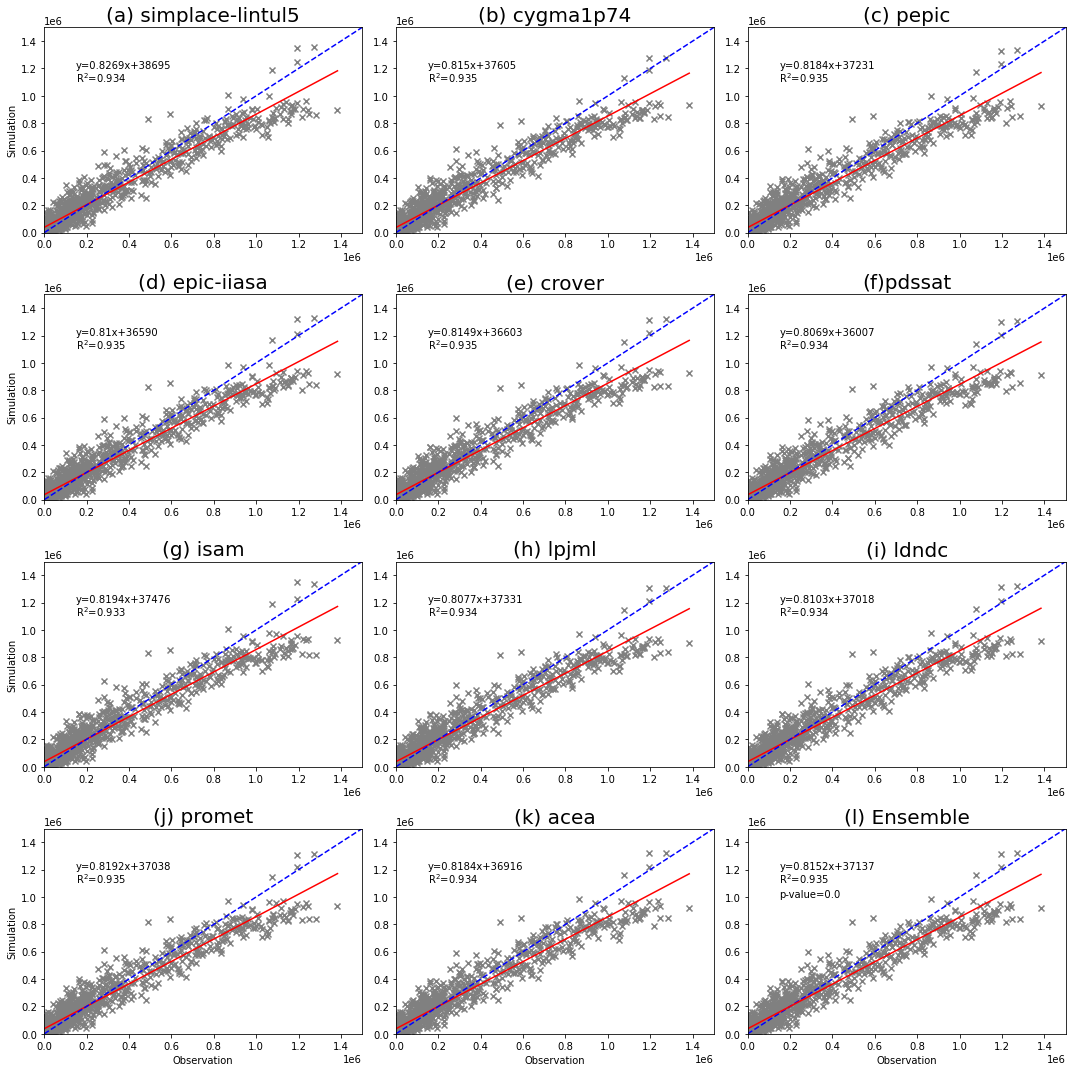

In [27]:
production_1995to2014=np.empty(shape=(13,60,60)) # 1-11: 11 models; 12: ensemble mean;13:spam data

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()
ii=0

for fn in fns:
    print(fn)
    ds=xr.open_dataset(fn,decode_times=False)
    #ds=xr.open_dataset(fn)
    #subtract data in space and time, fill nan with 0
    cropped_ds1 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('1995','2014'), irr=1.0).fillna(0)
    cropped_ds2 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('1995','2014'), irr=2.0).fillna(0)
  
    #average over years and sum over irrigated and rainfed
    crop_isimip3a1_mean=cropped_ds1.mean(dim='years')*rainfed_landuse/100
    crop_isimip3a2_mean=cropped_ds2.mean(dim='years')*irrigated_landuse/100
    crop_isimip3a_mean= crop_isimip3a1_mean+crop_isimip3a2_mean
#     #these data are change in % relative to average for the period of 1983 to 2013
#     averages1983_2013 = cropped_ds.sel(years=slice("1996", "2015")).mean(dim='years')+100
#     #theoritically the average values for the reference periods are 100s at all grid points
#     averages1996_2015 = cropped_ds.sel(years=slice("1996", "2015")).mean(dim='years')+100
#     averages2040_2069 = cropped_ds.sel(years=slice("2040", "2069")).mean(dim='years')+100
#     averages2070_2099 = cropped_ds.sel(years=slice("2070", "2099")).mean(dim='years')+100
#     averages2050s_ssp585=(averages2040_2069/averages1996_2015-1)*average_all
#     averages2080s_ssp585=(averages2070_2099/averages1996_2015-1)*average_all
    data=crop_isimip3a_mean['yield'].values.squeeze()*areainsqmeter/10000
    production_1995to2014[ii,:,:]=data;
    if ii==0:
        ensembleMean=data/11
    else:
        ensembleMean=ensembleMean+data/11
    data=np.where(data == 0, np.nan, data)
    #spam_production
        
    X = spam_production.ravel()
    Y = data.ravel()
    X[X<=0]=np.nan
    Y[Y<=0]=np.nan    
    mask = [~np.isnan(X) & ~np.isnan(Y)] 
    X=X[mask]
    Y=Y[mask]
    # Add a constant term to the independent variable for intercept estimation
    X_with_const = sm.add_constant(X)
    # Fit the linear regression model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()
    # Print the summary
    #print(results.summary())  

    coefficients1 = np.polyfit(X, Y, 1)
    regression_line1 = np.polyval(coefficients1, [np.min(X),np.max(X)])
    

    ax=axes[ii]
    ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
    ax.plot([np.min(X),np.max(X)], regression_line1, color='red')
    ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
    ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
    #ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
    ax.set_xlim([0,1500000])
    ax.set_ylim([0,1500000])
    x_values = np.linspace(0, 1500000, 1000000)

    # Plot the dashed line y = x
    ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
    if (ii>8):
        ax.set_xlabel('Observation')
    if (ii==0 or ii==3 or ii==6 or ii==9):
        ax.set_ylabel('Simulation')
    plt.title('Production')
    ax.set_title(name_ggcms[ii], fontsize=20)

#     ax.set_xlim(0,15)
#     ax.set_ylim(0,15)    
    ii=ii+1
production_1995to2014[11,:,:]=ensembleMean
production_1995to2014[12,:,:]=spam_production
data=np.where(ensembleMean <= 0, np.nan, ensembleMean)
#/spam_production
X = spam_production.ravel()
Y=data.ravel()
X[X<=0]=np.nan
Y[Y<=0]=np.nan
mask = ~np.isnan(X) & ~np.isnan(Y) 
X=X[mask]
Y=Y[mask]
print([np.max(X),np.min(X),np.max(Y),np.min(Y)])
# Add a constant term to the independent variable for intercept estimation
X_with_const = sm.add_constant(X)
# Fit the linear regression model
model = sm.OLS(Y, X_with_const)
results = model.fit()
# Print the summary
#print(results.summary())  

coefficients1 = np.polyfit(X, Y, 1)

regression_line1 = np.polyval(coefficients1, [np.min(X),np.max(X)])
    
ax=axes[ii]
x_values = np.linspace(0, 1500000, 1000000)

# Plot the dashed line y = x
ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
ax.plot([np.min(X),np.max(X)], regression_line1, color='red')
ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
ax.set_xlim([0,1500000])
ax.set_ylim([0,1500000])

plt.xlabel('Observation')
#plt.ylabel('Simulation')
#plt.suptitle('Maize Production', fontsize=30)
ax.set_title(name_ggcms[ii], fontsize=20)
plt.tight_layout()

fig.savefig('Figure_3_isimip3a_production_observation_simulation_regression_for_maize.png',dpi=150)
#np.save('isimip3a_1995to2014_production.npy',production_1995to2014)

In [28]:
print([np.nansum(X),np.nansum(Y),np.nansum(Y)-np.nansum(X), np.nansum(Y)/np.nansum(X),np.nansum(Y)/np.nansum(X)-1])

[265638568.60668394, 260294048.62862197, -5344519.978061974, 0.9798804819417044, -0.020119518058295593]


In [29]:
X.shape

(1178,)